In [2]:
#Import
import pandas as pd
import numpy as np

#Data
import pickle

#Utilities
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, train_test_split, cross_val_score, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
import optuna

c:\Users\leth\AppData\Local\anaconda3\envs\THERMO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
smarts_list = [
    '[H]',    # H atoms
    '[C,c]',  # Carbon atoms - aliphatic or aromatic
    '[O]' ,   # Oxygen atoms
    '[C;R]',  # Ring carbon
    '[c;R]',  # Aromatic carbon
    '[O;R]',  # Oxygen in ring
    '[*R]',  # Any atom in a ring
    '[OX2]', # OH and ether
    '[OX2H]', # OH
    '[c][OX2H]', # Phenolic OH
    '[OX2H0]', # Ether
    '[CX3][OX1]', # Carbonyl
    '[#6][CX3H0](=O)[#6]', #Ketone
    '[CX3H1](=O)', # Aldehyde
    '[CX3](=O)[OX2H]', # Carboxylic acid
    '[CX3](=O)O[CX3](=O)', # Anhydride
    '[CX3H0](=O)[OX2H0][#6]',  # Ester
    '[CX4H0]' ,  # Carbon sp3 with no hydrogens
    '[CX4H1]',  # Carbon sp3 with 1 hydrogen
    '[CX4H2]',  # Carbon sp3 with 2 hydrogens
    '[CX4H3]',  # Carbon sp3 with 3 hydrogens
    '[CX3]=[CX3]', # Alkenes
    '[#8].[#8]',  # Molecules containing two oxygen atoms
    '[OX2H].[OX2H]', # At least 2 OH
    '[OX2H].[OX2H].[OX2H]', # At least 3 OH
    '[CX4][OX2H]', # Typical Alcohols
    '[CX4H0][OX2H]', # Tertiary Alcohols
    '[CX4H1][OX2H]', # Secondary Alcohols
    '[CX4H2][OX2H]', # Primary Alcohols
    '[CX3H2]=[CX3H1]',  # CH2=CH-
    '[CX3H2]=[CX3H1]',  # CH2=C()-
    '[CX3H1]=[CX3H1]',  # -CH=CH-
    '[OX2H0].[OX2H0]', # At least 2 ethers
    '[OX2H0].[OX2H0].[OX2H0]', # At least 3 ethers 
    '[c][OX2][c]', # Aromatic-Aromatic ether
    '[c][OX2][C]' , # Aromatic-Aliphatic ether
    '[#8][#6][#6][#8]', #1,2-diol or diether
    '[#8][#6][#6][#6][#8]', #1,3-diol or diether
    '[#6;R]-O-[#6;R]', #Cyclic ether
]

smarts_labels = [f'X{i+1}' for i in range(len(smarts_list))]

In [4]:
df = pd.read_excel("DIPPR.xlsx", sheet_name=0)
df.drop(columns=['Name', 'CAS', 'Family'], inplace=True)

# Group by SMILE and T, take mean of K
df_reduced = df.groupby(['SMILE', 'T'], as_index=False)['K'].mean()

In [5]:
#Polynpomial interpolation
interpolated_dfs = []

for smile, group in df_reduced.groupby('SMILE'):
    group = group.sort_values('T')

    # Reduce to at most 10 diverse points (evenly spread)
    if len(group) > 10:
        indices = np.linspace(0, len(group) - 1, 10, dtype=int)
        group = group.iloc[indices].reset_index(drop=True)

    # Interpolate over a denser T range if desired
    T_new = np.linspace(group['T'].min(), group['T'].max(), num=10)

    if len(group) >= 4: # Change if needed
        # Safe to fit cubic
        coeffs = np.polyfit(group['T'], group['K'], deg=2)
        poly = np.poly1d(coeffs)
        K_new = poly(T_new)
    
    else:
        # Fall back to linear if not enough points
        coeffs = np.polyfit(group['T'], group['K'], deg=1)
        poly = np.poly1d(coeffs)
        K_new = poly(T_new)


    interpolated = pd.DataFrame({
        'SMILE': smile,
        'T': T_new,
        'K': K_new
    })
    interpolated_dfs.append(interpolated)

result = pd.concat(interpolated_dfs, ignore_index=True)

In [6]:
# Convert SMILES to Mol objects
result['mol'] = result['SMILE'].apply(Chem.MolFromSmiles)

# Add explicit hydrogens to all molecules
result['mol'] = result['mol'].apply(lambda mol: Chem.AddHs(mol) if mol else None)

# Generate binary SMARTS descriptors
for smarts, label in zip(smarts_list, smarts_labels):
    pattern = Chem.MolFromSmarts(smarts)
    result[label] = result['mol'].apply(lambda mol: len(mol.GetSubstructMatches(pattern)) if mol else 0)

# Calculate molecular weight and add it to the DataFrame
result['MolWeight'] = result['mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol else None)

In [7]:
X = result.drop(columns=['SMILE', 'mol', 'K'])
y = result['K']

In [8]:
# Use SMILE as the group identifier for splitting
groups = result['SMILE']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.8, 1.0]
# }

# model = XGBRegressor(random_state=42)

# grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
# grid.fit(X_train, y_train)

# print("Best parameters:", grid.best_params_)
# print("Best CV R²:", grid.best_score_)

# best_model = grid.best_estimator_
# y_pred = best_model.predict(X_test)
# test_r2 = best_model.score(X_test, y_test)
# print(f"Test R²: {test_r2:.3f}")

In [9]:
cv = GroupKFold(n_splits=5)
groups_train = groups.iloc[train_idx]
scores = []

def objectives(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.4),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 1, 1.5),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1, groups=groups_train)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=20)

[I 2025-07-11 09:28:31,362] A new study created in memory with name: no-name-e2b586f8-fcca-4ce6-b4bf-7c0e2cbbd3f2
[I 2025-07-11 09:28:43,954] Trial 0 finished with value: 0.7701983241819252 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.28185120584492096, 'subsample': 0.6642078363932191}. Best is trial 0 with value: 0.7701983241819252.
[I 2025-07-11 09:28:47,567] Trial 1 finished with value: 0.7582377211795887 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.3146105461320028, 'subsample': 0.819741430748855}. Best is trial 0 with value: 0.7701983241819252.
[I 2025-07-11 09:28:50,271] Trial 2 finished with value: 0.774704736249411 and parameters: {'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.1863965528843115, 'subsample': 0.8362288783017986}. Best is trial 2 with value: 0.774704736249411.
[I 2025-07-11 09:28:50,450] Trial 3 finished with value: 0.737439915655675 and parameters: {'n_estimators': 123, 'max_depth': 6, 'learning_ra

In [10]:
optuna.visualization.plot_optimization_history(study).show()

In [11]:
best_params = study.best_params
print("Best parameters from Optuna:", best_params)

Best parameters from Optuna: {'n_estimators': 191, 'max_depth': 3, 'learning_rate': 0.3833848935037564, 'subsample': 0.9703916543282312}


In [12]:
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print(f"Final Test R²: {test_r2:.3f}")

Final Test R²: 0.955


APPLY MODEL TO SDB

In [13]:
sdb = pd.read_excel("sdb1_unique_pures+predict.xlsx", sheet_name=0)

# Convert SMILES to Mol objects
sdb['mol'] = sdb['SMILES'].apply(Chem.MolFromSmiles)

# Add explicit hydrogens to all molecules
sdb['mol'] = sdb['mol'].apply(lambda mol: Chem.AddHs(mol) if mol else None)

# Generate binary SMARTS descriptors
for smarts, label in zip(smarts_list, smarts_labels):
    pattern = Chem.MolFromSmarts(smarts)
    sdb[label] = sdb['mol'].apply(lambda mol: len(mol.GetSubstructMatches(pattern)) if mol else 0)

# Calculate molecular weight and add it to the DataFrame
sdb['MolWeight'] = sdb['mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol else None)

X = sdb.drop(columns=['Name', 'SMILES', 'mol', 'K', 'K_pred', '% difference'])
y = sdb['K']

In [14]:
# Custom params
custom_params = {'n_estimators': 290, 'max_depth': 3, 'learning_rate': 0.27864475109681996, 'subsample': 0.9062537228873638}
final_model = XGBRegressor(**custom_params, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_train_pred = final_model.predict(X_train)
print(f"Train R²: {r2_score(y_train, y_train_pred):.3f}")
test_r2 = r2_score(y_test, y_pred)
print(f"Test R²: {test_r2:.3f}")

Train R²: 0.996
Test R²: 0.967


In [15]:
preds_xgb = final_model.predict(X)
r2_xgb = r2_score(sdb['K'], preds_xgb)
r2_moreno= r2_score(sdb['K'], sdb['K_pred'])
print(f"R² for xgb predictions: {r2_xgb:.3f}")

R² for xgb predictions: 0.970


In [16]:
# Create df with columns y_test, y_pred, sdb['K'], preds_xgb
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
})

results_df2 = pd.DataFrame({
        'sdb_K': sdb['K'],
    'preds_xgb': preds_xgb
})

# Save the results to an Excel file
results_df.to_excel('placeholder.xlsx', index=False)
results_df2.to_excel('placeholder2.xlsx', index=False)

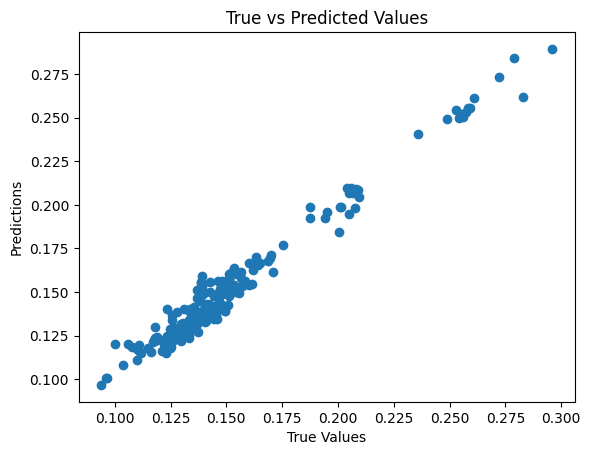

In [17]:
# Plot predictions vs actual
plt.scatter(sdb['K'], preds_xgb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

In [18]:
final_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.27864475109681996, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=290, n_jobs=None,
             num_parallel_tree=None, ...)>

APPLY TO ALL OF DB (Replace Exp Values)

In [19]:
db = pd.read_excel('../report/DB.xlsx', sheet_name=1)
df_A = db[['SMILES_A', 'T']].copy()
df_A.rename(columns={'SMILES_A': 'SMILES'}, inplace=True)
df_B = db[['SMILES_B', 'T']].copy()
df_B.rename(columns={'SMILES_B': 'SMILES'}, inplace=True)

In [20]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

def generate_smarts_descriptors(df, smiles_column='SMILES'):
    """
    Adds molecular representations, SMARTS-based substructure counts,
    and molecular weight to a DataFrame.

    Parameters:
    - df: pandas DataFrame with a column of SMILES strings.
    - smiles_column: name of the column containing SMILES (default: 'SMILE').

    Returns:
    - Modified DataFrame with SMARTS descriptors and MolWeight column.
    """
    
    smarts_list = [
        '[H]', '[C,c]', '[O]', '[C;R]', '[c;R]', '[O;R]', '[*R]', '[OX2]', '[OX2H]',
        '[c][OX2H]', '[OX2H0]', '[CX3][OX1]', '[#6][CX3H0](=O)[#6]', '[CX3H1](=O)',
        '[CX3](=O)[OX2H]', '[CX3](=O)O[CX3](=O)', '[CX3H0](=O)[OX2H0][#6]', '[CX4H0]',
        '[CX4H1]', '[CX4H2]', '[CX4H3]', '[CX3]=[CX3]', '[#8].[#8]', '[OX2H].[OX2H]',
        '[OX2H].[OX2H].[OX2H]', '[CX4][OX2H]', '[CX4H0][OX2H]', '[CX4H1][OX2H]',
        '[CX4H2][OX2H]', '[CX3H2]=[CX3H1]', '[CX3H2]=[CX3H0]', '[CX3H1]=[CX3H1]',
        '[OX2H0].[OX2H0]', '[OX2H0].[OX2H0].[OX2H0]', '[c][OX2][c]', '[c][OX2][C]',
        '[#8][#6][#6][#8]', '[#8][#6][#6][#6][#8]', '[#6;R]-O-[#6;R]'
    ]
    smarts_labels = [f'X{i+1}' for i in range(len(smarts_list))]

    df = df.copy()
    
    # Generate RDKit Mol objects and add explicit Hs
    df['mol'] = df[smiles_column].apply(Chem.MolFromSmiles)
    df['mol'] = df['mol'].apply(lambda mol: Chem.AddHs(mol) if mol else None)

    # Calculate SMARTS-based substructure counts
    for smarts, label in zip(smarts_list, smarts_labels):
        pattern = Chem.MolFromSmarts(smarts)
        df[label] = df['mol'].apply(lambda mol: len(mol.GetSubstructMatches(pattern)) if mol else 0)

    # Add molecular weight
    df['MolWeight'] = df['mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol else None)

    df.drop(columns=['mol'], inplace=True)  # Optionally drop the Mol column
    return df

In [21]:
df_A = generate_smarts_descriptors(df_A, smiles_column='SMILES')
df_A

,SMILES,T,X1,X2,X3,X4,X5,X6,X7,X8,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,MolWeight
0,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,304.01,20,10,1,6,0,0,6,1,...,0,0,0,0,0,0,0,0,0,156.269
1,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,314.00,20,10,1,6,0,0,6,1,...,0,0,0,0,0,0,0,0,0,156.269
2,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,324.01,20,10,1,6,0,0,6,1,...,0,0,0,0,0,0,0,0,0,156.269
3,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,333.98,20,10,1,6,0,0,6,1,...,0,0,0,0,0,0,0,0,0,156.269
4,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,344.15,20,10,1,6,0,0,6,1,...,0,0,0,0,0,0,0,0,0,156.269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,CCCCCCCCCCC,322.02,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,156.313
3049,CCCCCCCCCCC,331.75,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,156.313
3050,CCCCCCCCCCC,341.92,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,156.313
3051,CCCCCCCCCCC,351.90,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,156.313


In [22]:
df_B = generate_smarts_descriptors(df_B, smiles_column='SMILES')
df_B

,SMILES,T,X1,X2,X3,X4,X5,X6,X7,X8,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,MolWeight
0,CCCCCCCCCC(O)=O,304.01,20,10,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,172.268
1,CCCCCCCCCC(O)=O,314.00,20,10,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,172.268
2,CCCCCCCCCC(O)=O,324.01,20,10,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,172.268
3,CCCCCCCCCC(O)=O,333.98,20,10,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,172.268
4,CCCCCCCCCC(O)=O,344.15,20,10,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,172.268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,CCCCCCCCCCCCCC(=O)OC,322.02,30,15,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,242.403
3049,CCCCCCCCCCCCCC(=O)OC,331.75,30,15,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,242.403
3050,CCCCCCCCCCCCCC(=O)OC,341.92,30,15,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,242.403
3051,CCCCCCCCCCCCCC(=O)OC,351.90,30,15,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,242.403


In [23]:
df_A['K'] = final_model.predict(df_A.drop(columns=['SMILES']))
df_B['K'] = final_model.predict(df_B.drop(columns=['SMILES']))

In [24]:
# db = pd.read_excel('../report/DB.xlsx')
# db.drop(['KA', 'KB'], axis=1, inplace=True)
# db['KA'] = df_A['K']
# db['KB'] = df_B['K']
# db.to_excel('../report/DB_xgb_predict_all.xlsx', index=False)

APPLY TO UNIQUE DB

In [25]:
final_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.27864475109681996, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=290, n_jobs=None,
             num_parallel_tree=None, ...)>

In [26]:
db_unique = pd.read_excel('DB_unique.xlsx')
db_unique = generate_smarts_descriptors(db_unique, smiles_column='SMILES')
db_unique['K'] = final_model.predict(db_unique.drop(columns=['SMILES', 'Name']))

In [27]:
# db_unique_saved = db_unique[['Name', 'SMILES', 'T', 'K']].copy()
# db_unique_saved.to_excel('DB_unique_xgb_predictions.xlsx', index=False)

APPLY TO TESTS FOR 3-4-COMPONENTS

In [ ]:
# df_test = pd.read_excel('test_3_comp.xlsx')
# df_test = generate_smarts_descriptors(df_test, smiles_column='SMILES')
# df_test['K'] = final_model.predict(df_test.drop(columns=['SMILES']))

In [ ]:
df_test

,SMILES,T,X1,X2,X3,X4,X5,X6,X7,X8,...,X32,X33,X34,X35,X36,X37,X38,X39,MolWeight,K
0,CCCCCCC,293.75,16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.205,0.124622
1,CCCCCCC,304.25,16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.205,0.121923
2,CCCCCCC,314.35,16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.205,0.118217
3,CCCCCCC,323.95,16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.205,0.115246
4,CCCCCCC,334.65,16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.205,0.112323
5,CCCCCCC,344.05,16,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.205,0.110881
6,CCCCCCCCCCC,293.75,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,156.313,0.130356
7,CCCCCCCCCCC,304.25,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,156.313,0.128473
8,CCCCCCCCCCC,314.35,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,156.313,0.125618
9,CCCCCCCCCCC,323.95,24,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,156.313,0.123293


PREDICT MISC

In [43]:
# Load Excel file
df_wide = pd.read_excel("Pred-Comp-Jet.xlsx", sheet_name=0)
df_wide['RowOrder'] = df_wide.index
df_wide = df_wide.drop(columns=['Temperature (K)'], errors='ignore')
df_wide

,Famille,SMILES Cannonique,MM,223.15,248.15,273.15,298.15,323.15,348.15,373.15,...,473.15,498.15,523.15,548.15,573.15,598.15,623.15,648.15,673.15,RowOrder
0,n-paraffines,CCC,44.062600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,n-paraffines,CCCC,58.078250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,n-paraffines,CCCCC,72.093900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,n-paraffines,CCCCCC,86.109550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,n-paraffines,CCCCCCC,100.125201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Naphteno-di-aromatiques,CC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,348.281701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
242,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,362.297351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242
243,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,376.313001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243
244,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(...,390.328651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244


In [45]:
# Melt the DataFrame from wide to long format
df_long = df_wide.melt(id_vars=["Famille", "SMILES Cannonique", "MM", "RowOrder"],
                  var_name="T",
                  value_name="Thermal conductivity (W/mK)")

# Convert Temperature to float if needed
df_long["T"] = df_long["T"].astype(float)

print(df_long.head())

        Famille SMILES Cannonique          MM  RowOrder       T  \
0  n-paraffines               CCC   44.062600         0  223.15   
1  n-paraffines              CCCC   58.078250         1  223.15   
2  n-paraffines             CCCCC   72.093900         2  223.15   
3  n-paraffines            CCCCCC   86.109550         3  223.15   
4  n-paraffines           CCCCCCC  100.125201         4  223.15   

   Thermal conductivity (W/mK)  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  


In [46]:
df_jet = generate_smarts_descriptors(df_long, smiles_column='SMILES Cannonique')
df_jet

,Famille,SMILES Cannonique,MM,RowOrder,T,Thermal conductivity (W/mK),X1,X2,X3,X4,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,MolWeight
0,n-paraffines,CCC,44.062600,0,223.15,NaN,8,3,0,0,...,0,0,0,0,0,0,0,0,0,44.097
1,n-paraffines,CCCC,58.078250,1,223.15,NaN,10,4,0,0,...,0,0,0,0,0,0,0,0,0,58.124
2,n-paraffines,CCCCC,72.093900,2,223.15,NaN,12,5,0,0,...,0,0,0,0,0,0,0,0,0,72.151
3,n-paraffines,CCCCCC,86.109550,3,223.15,NaN,14,6,0,0,...,0,0,0,0,0,0,0,0,0,86.178
4,n-paraffines,CCCCCCC,100.125201,4,223.15,NaN,16,7,0,0,...,0,0,0,0,0,0,0,0,0,100.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,Naphteno-di-aromatiques,CC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,348.281701,241,673.15,NaN,36,26,0,4,...,0,1,0,0,0,0,0,0,0,348.574
4670,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,362.297351,242,673.15,NaN,38,27,0,4,...,0,1,0,0,0,0,0,0,0,362.601
4671,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,376.313001,243,673.15,NaN,40,28,0,4,...,0,1,0,0,0,0,0,0,0,376.628
4672,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(...,390.328651,244,673.15,NaN,42,29,0,4,...,0,1,0,0,0,0,0,0,0,390.655


In [47]:
df_jet['Thermal conductivity (W/mK)'] = final_model.predict(df_jet.drop(columns=['SMILES Cannonique', 'Famille', 'MM', 'Thermal conductivity (W/mK)', 'RowOrder']))

In [48]:
df_jet

,Famille,SMILES Cannonique,MM,RowOrder,T,Thermal conductivity (W/mK),X1,X2,X3,X4,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,MolWeight
0,n-paraffines,CCC,44.062600,0,223.15,0.139417,8,3,0,0,...,0,0,0,0,0,0,0,0,0,44.097
1,n-paraffines,CCCC,58.078250,1,223.15,0.136903,10,4,0,0,...,0,0,0,0,0,0,0,0,0,58.124
2,n-paraffines,CCCCC,72.093900,2,223.15,0.140692,12,5,0,0,...,0,0,0,0,0,0,0,0,0,72.151
3,n-paraffines,CCCCCC,86.109550,3,223.15,0.141852,14,6,0,0,...,0,0,0,0,0,0,0,0,0,86.178
4,n-paraffines,CCCCCCC,100.125201,4,223.15,0.143666,16,7,0,0,...,0,0,0,0,0,0,0,0,0,100.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,Naphteno-di-aromatiques,CC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,348.281701,241,673.15,0.093152,36,26,0,4,...,0,1,0,0,0,0,0,0,0,348.574
4670,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,362.297351,242,673.15,0.089518,38,27,0,4,...,0,1,0,0,0,0,0,0,0,362.601
4671,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,376.313001,243,673.15,0.085310,40,28,0,4,...,0,1,0,0,0,0,0,0,0,376.628
4672,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(...,390.328651,244,673.15,0.086369,42,29,0,4,...,0,1,0,0,0,0,0,0,0,390.655


In [ ]:
mm_dif = df_jet['MolWeight'].to_numpy() - df_jet['MM'].to_numpy() 
mm_dif_mean = np.mean(mm_dif)
print(f"Mean difference between MolWeight and MM: {mm_dif_mean:.2f}")

Mean difference between MolWeight and MM: 0.22


In [49]:
# Return wide format dataframe
df_jet_reduced = df_jet[['SMILES Cannonique', 'Famille', 'MM', 'T', 'Thermal conductivity (W/mK)', 'RowOrder']]
df_wide_new = df_jet_reduced.pivot(index=["Famille", "SMILES Cannonique", "MM", "RowOrder"], 
                        columns="T", 
                        values="Thermal conductivity (W/mK)").reset_index()
df_wide_new

T,Famille,SMILES Cannonique,MM,RowOrder,223.15,248.15,273.15,298.15,323.15,348.15,...,448.15,473.15,498.15,523.15,548.15,573.15,598.15,623.15,648.15,673.15
0,Di-aromatiques,CCC(C)Cc1cc(C(C)CC)cc2c(CC(C)C)cc(C(CC)CC)cc12,380.344301,206,0.144521,0.141002,0.134268,0.131493,0.129639,0.126055,...,0.109745,0.106177,0.104412,0.099047,0.098601,0.096098,0.091702,0.085251,0.085251,0.085251
1,Di-aromatiques,CCC(C)Cc1cc(C(CC)CC)cc2c(CC(C)CC)cc(C(C)CC)cc12,394.359951,207,0.143312,0.139793,0.133059,0.130284,0.128430,0.124846,...,0.109496,0.106177,0.104412,0.099047,0.098601,0.096098,0.091702,0.085251,0.085251,0.085251
2,Di-aromatiques,CCC(C)c1cc(CC(C)C)c2cc(C(C)CC)cc(CC(C)C)c2c1,352.313001,204,0.139640,0.136121,0.129102,0.126501,0.124647,0.121064,...,0.105858,0.104877,0.103018,0.097653,0.097279,0.094776,0.090380,0.083917,0.083917,0.083917
3,Di-aromatiques,CCC(C)c1cc(CC(C)C)c2cc(C(CC)CC)cc(CC(C)C)c2c1,366.328651,205,0.145202,0.141684,0.134950,0.132350,0.130496,0.126912,...,0.109723,0.106155,0.104295,0.098931,0.098485,0.095982,0.091586,0.085251,0.085251,0.085251
4,Di-aromatiques,CCCC(C)c1cc(CC(C)CC)c2cc(C(CC)CC)cc(CC(C)CC)c2c1,408.375602,208,0.142915,0.139397,0.132663,0.129887,0.128033,0.125273,...,0.109746,0.107330,0.105565,0.100200,0.099755,0.097251,0.092855,0.086350,0.086350,0.086350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,n-paraffines,CCCCCCCCCCCCCCCCCCCCCCCCCC,366.422552,23,0.169515,0.165020,0.158512,0.156685,0.152376,0.147362,...,0.126519,0.121843,0.119879,0.115422,0.113974,0.111184,0.106778,0.095102,0.095102,0.095102
242,n-paraffines,CCCCCCCCCCCCCCCCCCCCCCCCCCC,380.438202,24,0.169515,0.165020,0.158512,0.156685,0.152376,0.147362,...,0.126519,0.121843,0.119879,0.115422,0.113974,0.111184,0.106778,0.095102,0.095102,0.095102
243,n-paraffines,CCCCCCCCCCCCCCCCCCCCCCCCCCCC,394.453852,25,0.169515,0.165020,0.158512,0.156685,0.152376,0.147362,...,0.126519,0.121843,0.119879,0.115422,0.113974,0.111184,0.106778,0.095102,0.095102,0.095102
244,n-paraffines,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,408.469502,26,0.168556,0.164061,0.157553,0.155726,0.151416,0.146403,...,0.126519,0.121843,0.119879,0.115422,0.113974,0.111184,0.106778,0.095102,0.095102,0.095102


In [50]:
df_wide_sorted = df_wide_new.sort_values('RowOrder').drop(columns='RowOrder')
df_wide_sorted

T,Famille,SMILES Cannonique,MM,223.15,248.15,273.15,298.15,323.15,348.15,373.15,...,448.15,473.15,498.15,523.15,548.15,573.15,598.15,623.15,648.15,673.15
218,n-paraffines,CCC,44.062600,0.139417,0.132335,0.119435,0.113647,0.105767,0.103845,0.098236,...,0.086230,0.084408,0.082410,0.079826,0.077355,0.077569,0.076308,0.062526,0.062526,0.062526
219,n-paraffines,CCCC,58.078250,0.136903,0.132522,0.122832,0.121750,0.114142,0.107329,0.101720,...,0.089389,0.087567,0.085569,0.082683,0.080213,0.080043,0.077714,0.063571,0.063571,0.063571
220,n-paraffines,CCCCC,72.093900,0.140692,0.137023,0.122835,0.117130,0.109283,0.108033,0.102317,...,0.089986,0.088163,0.086165,0.083961,0.082772,0.081418,0.078839,0.066633,0.066633,0.066633
221,n-paraffines,CCCCCC,86.109550,0.141852,0.138576,0.127021,0.121436,0.113215,0.109106,0.103390,...,0.092059,0.090236,0.088129,0.086269,0.084997,0.083643,0.081064,0.068811,0.068811,0.068811
222,n-paraffines,CCCCCCC,100.125201,0.143666,0.140390,0.129529,0.123596,0.115246,0.109944,0.104368,...,0.089716,0.087538,0.085431,0.084931,0.083660,0.082306,0.078887,0.070097,0.070097,0.070097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Naphteno-di-aromatiques,CC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,348.281701,0.143872,0.140865,0.139887,0.136222,0.133765,0.127886,0.125122,...,0.112492,0.110986,0.108899,0.103484,0.102759,0.099859,0.095669,0.093152,0.093152,0.093152
98,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)C)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,362.297351,0.141547,0.138539,0.137378,0.133571,0.131771,0.124317,0.121553,...,0.109071,0.107212,0.105180,0.099815,0.099125,0.096225,0.092035,0.089518,0.089518,0.089518
99,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(C)C,376.313001,0.140959,0.137952,0.135900,0.132508,0.130709,0.122725,0.119961,...,0.107153,0.106173,0.104142,0.098777,0.098086,0.095187,0.090513,0.085310,0.085310,0.085310
100,Naphteno-di-aromatiques,CCC(C)c1ccc(C(C)CC)c2cc3c(cc12)C(C(C)C)C=CC3C(...,390.328651,0.145042,0.142747,0.140757,0.137365,0.135566,0.127582,0.123776,...,0.110744,0.107176,0.105144,0.099779,0.099017,0.096118,0.091444,0.086369,0.086369,0.086369


In [51]:
df_wide_sorted.to_excel('Pred-Comp-Jet_xgb_predictions_sorted.xlsx', index=False)